# EM algorithm with synthetic data

...two gaussian distributions to see if the EM comes anywhere close

In [1]:
import numpy as np
import math
import scipy as sp
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Math, Latex

import chart_studio as py
import plotly.figure_factory as FF
import plotly.graph_objs as go
from plotly import tools
import plotly.offline as offline
import plotly.io as pio

offline.init_notebook_mode()

import sys
sys.path.append("../../")
import pyhilbert as hil
import pyredmod as rm

%matplotlib inline

pio.orca.config.executable = '/Applications/orca.app/Contents/MacOS/orca'
pio.orca.config.save()

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
def cm_2_rgbstr(c):
    return f'rgb({int(round(c[0]*255))}, {int(round(c[1]*255))}, {int(round(c[2]*255))})'
def cma_2_rgbstr(c, a):
    return f'rgba({int(round(c[0]*255))}, {int(round(c[1]*255))}, {int(round(c[2]*255))}, {a})'
def col_2_scale(c, div=10):
    zs = np.linspace(0.,1.,div+1,endpoint=True)
    cs = [[z, cm_2_rgbstr(1.0 - z * (1.0 -  np.array(c)))] for z in zs]
    return cs

cm=sns.color_palette('Set1', n_colors=13)
axis_layout = dict(autorange=False, showgrid=False, zeroline=False, showline=False, 
                   ticks='', showticklabels=False, title='')
layout = go.Layout(width=800, height=400, showlegend=False,
                   margin=go.layout.Margin(l=40, r=40, b=20, t=20, pad=10),
                   xaxis=axis_layout, yaxis=axis_layout,
                   paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(0,0,0,0)',
                   title={'text':'','y':0.9,'x':0.5,'xanchor': 'center','yanchor': 'top'})
layout['xaxis'].update(range=[-2.4, 2.4])
layout['yaxis'].update(range=[-1.2, 1.2])

sample_marker = dict(color=cma_2_rgbstr(cm[0], 0.7), size=4, symbol='circle')
mean_marker = dict(color=cm_2_rgbstr((0,0,0)), size=4, symbol='square', line=dict(color=cm_2_rgbstr((0,0,0)), width=3))
param_marker = dict(color=cm_2_rgbstr(cm[0]), size=4, symbol='circle')

def make_ellipse(mean, V, sigma, color=(0,0,0), opacity=0.5):
    phi = np.linspace(0, 2*math.pi)
    x = np.sin(phi)*sigma[0]*V[0,0] + np.cos(phi)*sigma[1]*V[0,1]
    y = np.sin(phi)*sigma[0]*V[1,0] + np.cos(phi)*sigma[1]*V[1,1]
    return go.Scatter(x=mean[0] + x.flatten(),y=mean[1] + y.flatten(), 
                       mode='lines', line=dict(width=1.5, color=cma_2_rgbstr(color, opacity)), showlegend=False)

def make_gaussian_plot(mean, V, sigma, color=(0,0,0), opacity=0.5):
    # Makes a collection of Plotly graph objects: The mean, the ellipse corresponding to 1 x Sigma,
    # and the ellipse corresponding to 2 x sigma
    centre_marker = mean_marker
    centre_marker['line']['color']=cma_2_rgbstr(color, opacity)
    centre_marker['color']=cma_2_rgbstr(color, opacity)
    fig_gaussian = [make_ellipse(mean, V, sigma, color=color), make_ellipse(mean, V, 2*sigma, color=color),
                    go.Scatter(x=[mean[0]], y=[mean[1]], mode='markers', marker=centre_marker, showlegend=False)]
    return fig_gaussian

In [4]:
R2 = hil.Space(2)

def thick_sin(x, sigma=0.8, noise_sigma=0.025):
    # x is in [0,1]. We make a "thick sin" that is bluerred by a small Gaussian

    x0 = sp.stats.norm.ppf(x[:,0], scale=sigma)
    p = np.array([x0, np.cos(np.pi * x0)])
    eps = np.random.randn(2,len(x)) * noise_sigma
    
    return hil.Basis(p + eps, space=R2)

# 200 points on the [0,1]^2 square
n1 = 120; n2 = 80; N = n1+n2

def rot(theta):
    return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

mean1 = np.array([[0.7], [0.1]]); mean2 = np.array([[-0.2], [-0.2]])
phi1 = rot(np.pi/6); phi2 = rot(-np.pi/4)
sigma1 = np.array([0.6, 0.2]); sigma2 = np.array([0.6, 0.1])
points1 = phi1 @ (sigma1 * np.random.randn(2, n1).T).T + mean1
points2 = phi2 @ (sigma2 * np.random.randn(2, n2).T).T + mean2
points = np.concatenate((points1, points2), axis=1)
sorter = np.argsort(points[0])
points = points.T[sorter].T
U = hil.Basis(points, R2)

sample_marker['color'] = cm_2_rgbstr(cm[0])        
tr_samps = go.Scatter(x=U[0,:], y=U[1,:], mode='markers', marker=sample_marker, showlegend=False)

ell1 = make_ellipse(mean1, phi1, sigma1)
ell2 = make_ellipse(mean2, phi2, sigma2)
ell12 = make_ellipse(mean1, phi1, 2*sigma1)
ell22 = make_ellipse(mean2, phi2, 2*sigma2)
mean_marker['line']['color'] = cm_2_rgbstr((0,0,0))
mean1f = go.Scatter(x=[mean1[0,0]], y=[mean1[1,0]], mode='markers', marker=mean_marker, showlegend=False)
mean2f = go.Scatter(x=[mean2[0,0]], y=[mean2[1,0]], mode='markers', marker=mean_marker, showlegend=False)

fig = go.Figure(data=[tr_samps, ell1, ell2, ell12, ell22, mean1f, mean2f], layout=layout)
offline.iplot(fig)

Above we have the synthetic data, 200 points generated from two Gaussians, with 120 from the first Gaussian and 80 from the second. That means we have weights of $\alpha_1 = 3/5$ and $\alpha_2 = 2/5$ in the Gaussian mixture that generate the points.

Now, in the EM procedure below, we start with a naive estimate that fits a Gaussian with PCA on the first 18 samples and another of the remaining points. We see it doesn't reflect the data well, but within about 10 steps the EM procedure converges reasonably well.

In [5]:
est1 = rm.GaussianEstimator.from_samples(U[:18])
est2 = rm.GaussianEstimator.from_samples(U[18:])
mixture_est = rm.MixtureEstimator(estimators=[est1, est2], probs=[0.5, 0.5])

../../pyredmod/pyredmod/gauss_approx.py:141: UserWarning:

GaussianEstimator: Setting new Vn space



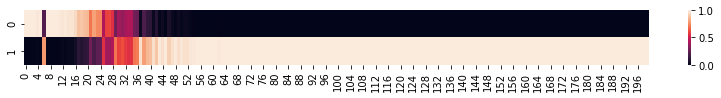

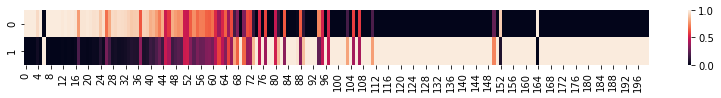

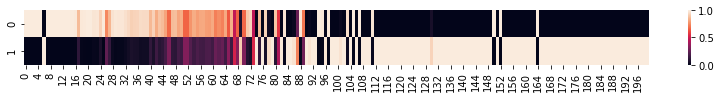

In [6]:
colorscales=['Reds', 'Blues', 'Greens']
sizes = [12, 8, 4]
offset = [-0.05, 0.05]

for j in range(11):
    rik = mixture_est.EM_step(U)
    #print(mixture_est.sum_log_exp(U)[0]*np.exp(mixture_est.sum_log_exp(U)[1]))
    if j == 0 or j == 5 or j == 10:
        layout['title']=f'EM step {j}'
        
        fig_data = []
        for n_i, (est, prob) in enumerate(mixture_est):
            # est = node.gauss_est
            # prob = node.prob
            sample_marker['color'] = cm_2_rgbstr(cm[n_i])
            mean_marker['line']['color'] = cm_2_rgbstr(cm[n_i])
            mean_marker['line']['width'] = 4

            c_mean = est.mean.values
            samples = U.values
            phi = est.Phi.values
            sig = est.sigma
            if n_i > 0:
                fig_s = go.Scatter(x=samples[0,:], y=samples[1,:], mode='markers', 
                                   marker=dict(color=rik[n_i, :], colorscale=colorscales[n_i], size=sizes[n_i], symbol='circle', cmax=1.0, cmin=0.0))
            else:
                fig_s = go.Scatter(x=samples[0,:], y=samples[1,:], mode='markers', 
                                   marker=dict(color=rik[n_i,:], colorscale=colorscales[n_i], size=sizes[n_i], symbol='circle', cmax=1.0, cmin=0.0))
            fig_data.append(fig_s)
            fig_m = go.Scatter(x=[c_mean[0]], y=[c_mean[1]], mode='markers', marker=mean_marker,
                                 showlegend=False)
            fig_data.append(fig_m)

            for s, v in zip(sig, phi.T):
                fig_v = go.Scatter(x=[c_mean[0],c_mean[0]+s*v[0]], y=[c_mean[1],c_mean[1]+s*v[1]],
                                   mode='lines', line=dict(width=1.5, color=cma_2_rgbstr(cm[n_i], 1.0)), showlegend=False)
                fig_data.append(fig_v)

            fig_data.append(make_ellipse(c_mean, phi, sig, cm[n_i], opacity=1.0))
            fig_data.append(make_ellipse(c_mean, phi, 2.0*sig, cm[n_i], opacity=0.5))

            # Comment this out for labels!
            #r_label = [f'{i}: {rval:0.2e}' for i, rval in enumerate(rik[n_i,:])]
            #fig_l = go.Scatter(x=samples[0,:], y=samples[1,:]+offset[n_i], mode='text', text=r_label,
            #                     showlegend=False)
            #fig_data.append(fig_l)
        if j == 10:
            fig_data.append(ell1); fig_data.append(ell2); fig_data.append(ell12); fig_data.append(ell22); fig_data.append(mean1f); fig_data.append(mean2f)

        fig = go.Figure(data=fig_data, layout=layout)
        offline.iplot(fig)
        #pio.write_image(fig, f'figs/synth_EM_step_{j}.pdf')

        fig = plt.figure(figsize=(14,1))
        sns.heatmap(rik)
        plt.show()
